# Code Overview: Importing Libraries and Setting Up the Environment

---

## 1. **Standard Library Imports**
The following Python libraries are used for core functionalities:
- **`os`**: For file and directory manipulation.
- **`tarfile`**: To handle compressed `.tar` files.
- **`time`**: For measuring execution time.
- **`random`**: For random number generation.
- **`glob`**: For file pattern matching.
- **`collections.Counter`**: To count occurrences of items in collections.
- **`PIL.Image`**: For image handling and preprocessing.
- **`matplotlib.pyplot`**: For data visualization.

---

## 2. **Visualization and Dimensionality Reduction**
- **`sklearn.manifold.TSNE`**: For visualizing high-dimensional data using t-SNE (t-distributed Stochastic Neighbor Embedding).

---

## 3. **PyTorch Imports**
- **Core PyTorch**:
  - **`torch`**: PyTorch's core library.
  - **`torch.nn`**: For building neural networks.
  - **`torch.nn.functional`**: For using activation functions and loss functions.
  - **`torch.optim`**: For optimization algorithms.
- **Data Handling**:
  - **`torch.utils.data`**: Includes `Dataset`, `DataLoader`, and tools for splitting datasets and sampling.
- **Transformations and Datasets**:
  - **`torchvision.transforms`**: For image preprocessing and augmentations.
  - **`torchvision.datasets`**: Provides access to common datasets.

---

## 4. **Additional Library Installation**
- **Install `timm`**:
  - `timm` is a library for pre-trained image models, providing access to various state-of-the-art architectures.
  - Installed via `!pip install timm -q` (quiet mode to suppress unnecessary logs).

---

## 5. **Importing `timm`**
- After installation, `timm` is imported to create pre-trained models.

---

## 6. **Google Drive Integration**
- **Mount Google Drive**:
  - Uses `drive.mount()` to link the Colab environment with a Google Drive folder for storing and accessing data.

In [ ]:
# Import Standard Libraries
import os
import tarfile
import time
import random
import glob
from PIL import Image
from collections import Counter

#Plotting
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Import PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from torchvision import datasets

# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl

# Install and Import timm for transformer architecture
!pip install timm -q
import timm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract `.tar.xz` File to a Specified Directory

### **Code Description**:
1. **Input Parameters**:
   - **`tar_file_path`**: Path to the `.tar.xz` archive file to be extracted.
   - **`extract_to_path`**: Directory where the archive contents will be extracted.

2. **Functionality**:
   - Creates the target directory if it doesn't already exist.
   - Opens the `.tar.xz` file in read mode and extracts its contents into the specified directory.

3. **Output**:
   - No return value. Files are extracted directly to the target directory.

---

### **Code Usage**:
- Initializes a variable `tar_file_path`, which stores the path for the unlabelled data folder stored on Google Drive.
- Initializes a variable `unlabelled_data`, which becomes the path to the extracted unlabelled data directory.

---

### **Example Code**:
```python
# Initialize file paths
tar_file_path = '/content/drive/My Drive/huron_unlabeled_data.tar.xz'
unlabelled_data = '/content/extracted_data'

# Function to extract the .tar.xz file
extract_tar_xz(tar_file_path, unlabelled_data)


In [ ]:
def extract_tar_xz(tar_file_path, extract_to_path):
    """
    Extracts the contents of a .tar.xz file to a specified directory.

    Input:
    - tar_file_path (str): The path to the .tar.xz archive file to be extracted.
    - extract_to_path (str): The directory path where the contents will be extracted.

    Output:
    - None: The function performs an extraction operation and does not return a value.
    """

    # Creates the specified directory if it doesn't already exist
    os.makedirs(extract_to_path, exist_ok=True)

    # Opens the specified .tar.xz file in read mode
    with tarfile.open(tar_file_path, 'r:xz') as tar:
        print("Extracting files...")

        # Extracts all files from the .tar.xz archive to the specified directory
        tar.extractall(path=extract_to_path)

        print("Extraction completed successfully!")


#File Paths
tar_file_path = '/content/drive/My Drive/huron_unlabeled_data.tar.xz'
unlabelled_data = '/content/unlabelled_data'

extract_tar_xz(tar_file_path, unlabelled_data)

Extracting files...
Extraction completed successfully!


## Custom Dataset Class: `UnlabeledDataset`

The `UnlabeledDataset` class is a PyTorch `Dataset` implementation designed for self-supervised learning tasks. It generates multiple augmented views of unlabeled images for contrastive learning or similar methods.

---

### Key Features:

1. **Initialization (`__init__`)**:
   - **Inputs**:
     - `image_dir`: Path to the directory containing the image files.
     - `global_transform`: Transformations applied to generate "global views" (e.g., high-resolution or large crops).
     - `local_transform`: Transformations applied to generate "local views" (e.g., smaller crops or patches).
     - `num_global_views`: Number of global views generated per image (default: 2).
     - `num_local_views`: Number of local views generated per image (default: 4).
   - **Behavior**:
     - Recursively searches the `image_dir` for all image files and stores their paths.
     - Warns if no image files are found.
     - Stores the transformations and the number of views for later use.

2. **Length (`__len__`)**:
   - Returns the number of images in the dataset.

3. **Retrieval (`__getitem__`)**:
   - **Inputs**:
     - `idx`: Index of the image in the dataset.
   - **Outputs**:
     - A list of augmented views (both global and local) of the specified image.
   - **Behavior**:
     - Opens the image and converts it to RGB.
     - Handles missing or corrupt image files gracefully, printing an error message.
     - Applies the specified transformations (`global_transform` and `local_transform`) to create the augmented views.

4. **Error Handling**:
   - Skips over corrupt or missing files without interrupting the dataset processing.

---

In [ ]:
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, global_transform=None, local_transform=None, num_global_views=2, num_local_views=4):
        """
        Initializes the UnlabeledDataset.

        Input:
        - image_dir (str): The directory containing the image files.
        - global_transform (callable, optional): Transformations applied to generate global views.
        - local_transform (callable, optional): Transformations applied to generate local views.
        - num_global_views (int): Number of global views per image.
        - num_local_views (int): Number of local views per image.

        Output:
        - None: This initializer sets up attributes needed to handle the dataset.
        """

        # Initialize the image directory and retrieve image files
        self.image_dir = image_dir
        self.image_files = glob.glob(os.path.join(image_dir, '**', '*'), recursive=True)

        # Check if any image files were found, otherwise print a warning
        if not self.image_files:
            print("No image files found. Check the extraction path and file extensions.")
        else:
            print(f"Number of images found: {len(self.image_files)}")

        # Store the transformations and number of views
        self.global_transform = global_transform
        self.local_transform = local_transform
        self.num_global_views = num_global_views
        self.num_local_views = num_local_views

    def __len__(self):

        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retrieves an image and applies transformations to create multiple views.

        Input:
        - idx (int): Index of the image in the dataset.

        Output:
        - list: A list of augmented views for the specified image.
        """

        # Get the path for the image at the specified index
        img_path = self.image_files[idx]

        # Try to open the image, skipping it if an error occurs
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError) as e:
            print(f"Error loading image at {img_path}: {e}")
            return None

        # Generate multiple augmented views of the image
        views = []

        # Apply global transformations
        for _ in range(self.num_global_views):
            if self.global_transform:
                views.append(self.global_transform(image))

        # Apply local transformations
        for _ in range(self.num_local_views):
            if self.local_transform:
                views.append(self.local_transform(image))

        return views


# Data Augmentation for Self-Supervised Learning

**Global (Teacher)** augmentations and **Local (Student)** augmentations.

---

### Dataset Statistics:
- **Mean**: `[0.8786, 0.8474, 0.8732]`
- **Standard Deviation**: `[0.2504, 0.2687, 0.2513]`

These values are used for normalizing images to a standard scale calculated from the unlabelled dataset.

---

### Augmentation Pipelines:

1. **Global (Teacher) Augmentations**:
   - Focus on **large portions** of the image.
   - **Transforms**:
     - `RandomResizedCrop(224, scale=(0.8, 1.0))`: Randomly crop a large portion of the image and resize to 224x224.
     - `RandomHorizontalFlip(p=0.5)`: Randomly flip the image horizontally.
     - `RandomVerticalFlip(p=0.5)`: Randomly flip the image vertically.
     - `ColorJitter`: Adjust brightness, contrast, saturation, and hue with a probability of 80%.
     - `RandomRotation`: Rotate the image randomly up to ±10 degrees.
     - `GaussianBlur`: Apply Gaussian blur with a probability of 50%.
     - `ToTensor`: Convert the image to a PyTorch tensor.
     - `Normalize`: Normalize the tensor with the specified mean and standard deviation.

2. **Local (Student) Augmentations**:
   - Focus on **smaller regions** of the image.
   - **Transforms**:
     - `RandomResizedCrop(224, scale=(0.6, 0.8))`: Randomly crop a smaller portion of the image and resize to 224x224.
     - `RandomVerticalFlip(p=0.3)`: Randomly flip the image vertically.
     - `RandomHorizontalFlip(p=0.3)`: Randomly flip the image horizontally.
     - `ColorJitter`: Adjust brightness, contrast, saturation, and hue.
     - `GaussianBlur`: Apply Gaussian blur with a probability of 30%.
     - `RandomRotation`: Rotate the image randomly up to ±5 degrees with a probability of 30%.
     - `ToTensor`: Convert the image to a PyTorch tensor.
     - `Normalize`: Normalize the tensor with the specified mean and standard deviation.

In [ ]:
mean = [0.8786, 0.8474, 0.8732]
std = [0.2504, 0.2687, 0.2513]


# Global (Teacher) Augmentations
global_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Slightly larger focus for medical images
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02)],
        p=0.7
    ),
    transforms.RandomRotation(degrees=5),  # Reduce rotation to preserve structural information
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.0))],  #
        p=0.3
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Standard normalization
])

# Local (Student) Augmentations
local_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.3, 0.6)),  # Focus on smaller regions
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.3, hue=0.03),  # Subtle changes
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8))],  # Slight blur
        p=0.2
    ),
    transforms.RandomApply(
        [transforms.RandomRotation(degrees=3)],  # Very small rotation
        p=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Standard normalization
])



# Dataset Preparation and DataLoader for Unlabeled Data

This code sets up the dataset and DataLoader using the **UnlabeledDataset** class. It applies global and local augmentations to generate multiple views of the images.

---

### Key Components:

1. **Directory for Unlabelled Data**:
   - The dataset is located in the directory:
     ```
     /content/unlabelled_data/Huron_Unlabeled_Data/
     ```

2. **Dataset Initialization**:
   - **Class**: `UnlabeledDataset`
   - **Parameters**:
     - `image_dir`: Directory containing the image files.
     - `global_transform`: Transformations for generating **global views**.
     - `local_transform`: Transformations for generating **local views**.
     - `num_global_views`: Number of global views per image (default: 2).
     - `num_local_views`: Number of local views per image (default: 4).

3. **DataLoader**:
   - **Parameters**:
     - `batch_size`: **128** images per batch.
     - `shuffle`: Enabled to randomize the order of data in each epoch.
     - `num_workers`: Set to 0 (useful for Colab; increase for local machines).
     - `drop_last`: Ensures all batches have equal size by dropping incomplete ones.

---

In [ ]:
# Directory for extracted data
image_directory = '/content/unlabelled_data/Huron_Unlabeled_Data/'

dataset = UnlabeledDataset(
    image_dir=image_directory,
    global_transform=global_transforms,
    local_transform=local_transforms,
    num_global_views=2,  # Adjust as needed
    num_local_views=4    # Adjust as needed
)

data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=0
)



Number of images found: 16352


# Visualization for Augmented Views

---

### 1. `denormalize` Function
Denormalizes a tensor by reversing the normalization applied during preprocessing.

#### Parameters:
- **`tensor`**: A normalized image tensor.
- **`mean`**: List of means used for normalization.
- **`std`**: List of standard deviations used for normalization.

#### Returns:
- A denormalized tensor.

---

### 2. `tensor_to_image` Function
Converts a denormalized tensor to a PIL image for display.

#### Parameters:
- **`tensor`**: A normalized image tensor.
- **`mean`**: List of means used for normalization.
- **`std`**: List of standard deviations used for normalization.

#### Returns:
- A PIL image ready for display.

---

### 3. `visualize_augmentations` Function
Visualizes the original image and its augmented views (global and local) for a random sample from the dataset.

#### Parameters:
- **`dataset`**: The `UnlabeledDataset` instance containing the images and augmentations.
- **`mean`**: List of means used for normalization.
- **`std`**: List of standard deviations used for normalization.
- **`num_global_views`**: Number of global views generated per image (default: 2).

#### Steps:
1. **Original Image**:
   - Displays the original image from the dataset.
2. **Global Views**:
   - Displays the augmented global views.
3. **Local Views**:
   - Displays the augmented local views.

#### Example Usage:
```python
# Visualize augmentations
visualize_augmentations(
    dataset=dataset,
    mean=[0.8786, 0.8474, 0.8732],
    std=[0.2504, 0.2687, 0.2513],
    num_global_views=2
)


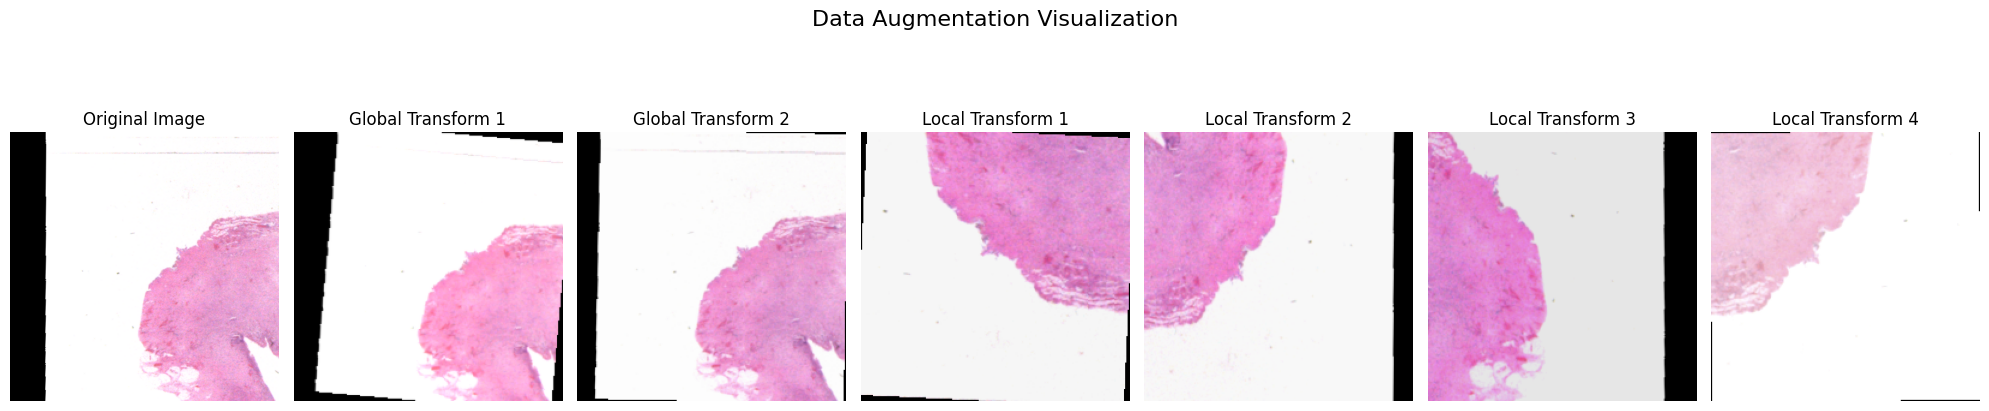

In [ ]:
def denormalize(tensor, mean, std):
    tensor = tensor.clone()  # Clone tensor to avoid modifying the original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize by multiplying by std and adding mean
    return tensor

def tensor_to_image(tensor, mean, std):
    tensor = denormalize(tensor, mean, std)  # Denormalize the tensor
    tensor = torch.clamp(tensor, 0, 1)  # Clip values to [0, 1] for display
    return transforms.ToPILImage()(tensor)  # Convert tensor to PIL image

def visualize_augmentations(dataset, mean, std, num_global_views=2):
    if len(dataset) == 0:
        print("Error: Dataset is empty. Cannot visualize augmentations.")
        return

    # Get a random sample from the dataset
    random_idx = torch.randint(0, len(dataset), (1,)).item()
    original_image_path = dataset.image_files[random_idx]
    views = dataset[random_idx]

    if views is None:
        print(f"Warning: Unable to retrieve views for image at index {random_idx}. Skipping visualization.")
        return

    num_local_views = len(views) - num_global_views
    if len(views) != num_global_views + num_local_views:
        print(f"Error: Mismatch in expected and actual number of views for image at index {random_idx}.")
        return

    plt.figure(figsize=(20, 5))
    plt.suptitle("Data Augmentation Visualization", fontsize=16)

    # Display the original image
    plt.subplot(1, len(views) + 1, 1)
    original_image = Image.open(original_image_path).convert('RGB')
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Global views
    for i in range(num_global_views):
        plt.subplot(1, len(views) + 1, i + 2)
        plt.imshow(tensor_to_image(views[i], mean, std))
        plt.title(f"Global Transform {i + 1}")
        plt.axis('off')

    # Local views
    for i in range(num_global_views, len(views)):
        plt.subplot(1, len(views) + 1, i + 2)
        plt.imshow(tensor_to_image(views[i], mean, std))
        plt.title(f"Local Transform {i - num_global_views + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_augmentations(dataset, mean=mean, std=std, num_global_views=2)


# Implementation of `DINOHead` for Self-Supervised Learning

Projects input features into a space suitable for contrastive learning objectives, leveraging a multi-layer perceptron (MLP) and a weight-normalized linear layer.

---

### Class: `DINOHead`

#### Constructor (`__init__`)
Defines the architecture of the head, including an MLP and a final layer.

#### Parameters:
- **`in_dim`**: Input feature dimension (output from the backbone encoder).
- **`out_dim`**: Output feature dimension (dimensionality of the contrastive learning space).
- **`hidden_dim`** (default: `2048`): Dimension of the hidden layer in the MLP.
- **`bottleneck_dim`** (default: `256`): Dimension of the bottleneck layer in the MLP.

#### Architecture:
1. **MLP**:
   - First Layer: Linear layer mapping `in_dim` to `hidden_dim`.
   - Activation: GELU (Gaussian Error Linear Unit) for non-linearity.
   - Second Layer: Linear layer mapping `hidden_dim` to `bottleneck_dim`.
2. **Last Layer**:
   - A weight-normalized linear layer that maps `bottleneck_dim` to `out_dim` without bias.

---

### Forward Pass (`forward`)
Defines how data flows through the `DINOHead`.

#### Steps:
1. **Input Features**:
   - Accepts input features (output from the backbone encoder).
2. **MLP Transformation**:
   - Passes the input features through the MLP.
3. **Normalization**:
   - Normalizes the features to unit length using L2 normalization.
4. **Final Mapping**:
   - Maps the normalized features to the output space using the weight-normalized linear layer.

#### Parameters:
- **`x`**: Input tensor of shape `[batch_size, in_dim]`.

#### Returns:
- An output tensor of shape `[batch_size, out_dim]` representing features in the contrastive space.

---


In [ ]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=2048, bottleneck_dim=256):
        super(DINOHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))

    def forward(self, x):
        x = self.mlp(x)
        x = torch.nn.functional.normalize(x, p=2, dim=-1)
        return self.last_layer(x)

# Implementation of `DINOLoss` for Self-Supervised Learning:

Aligns the student's predictions with the teacher's, using a dynamic temperature schedule, multi-crop views, and a learnable center buffer for stability.

---

### Class: `DINOLoss`

#### Constructor (`__init__`)

Initializes the parameters and buffers required for the DINO loss computation.

#### Parameters:
- **`out_dim`**: Dimensionality of the output embeddings.
- **`ncrops`**: Number of augmented crops (views) generated per image.
- **`warmup_teacher_temp`**: Initial temperature for the teacher during the warmup phase.
- **`teacher_temp`**: Final temperature for the teacher after warmup.
- **`warmup_teacher_temp_epochs`**: Number of epochs for warming up the teacher's temperature.
- **`nepochs`**: Total number of training epochs.
- **`student_temp`** (default: `0.1`): Temperature applied to the student's output.
- **`center_momentum`** (default: `0.9`): Momentum used to update the center buffer.

#### Key Components:
1. **Center Buffer**:
   - A moving average of teacher outputs is stored in `self.center`, initialized as zeros. It stabilizes the teacher's output distribution over training.

2. **Teacher Temperature Schedule**:
   - A temperature schedule is created, linearly increasing during the warmup phase and fixed thereafter. This controls the sharpness of the teacher's probability distribution.

---

### Forward Pass (`forward`)

Defines the DINO loss computation for a batch of student and teacher outputs.

#### Parameters:
- **`student_output`**: Logits from the student network (`[batch_size, out_dim]`).
- **`teacher_output`**: Logits from the teacher network (`[batch_size, out_dim]`).
- **`epoch`**: Current training epoch, used to determine the teacher's temperature.

#### Steps:
1. **Normalize Student Output**:
   - Divide student logits by the student temperature and split them into `ncrops`.

2. **Softmax Teacher Output**:
   - Apply softmax to the teacher logits after adjusting by the teacher temperature and center. Split into `ncrops`.

3. **Cross-Entropy Loss**:
   - Compute the cross-entropy loss between the teacher's probabilities and the student's logits for all pairs of crops, excluding self-comparisons.

4. **Average Loss**:
   - Normalize the total loss by the number of valid crop comparisons (`ncrops * (ncrops - 1)`).

#### Returns:
- The average DINO loss for the batch.

---
### Center Update (`update_center`)

Updates the center buffer with a momentum-based moving average of the teacher outputs.

#### Parameters:
- **`teacher_output`**: Logits from the teacher network for the current batch.

#### Steps:
1. Compute the mean of the teacher's logits across the batch.
2. Update the center

---

In [ ]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global_crops, n_local_crops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1, center_momentum=0.9):
        """
        Initializes the DINO Loss.

        Args:
            out_dim (int): Dimension of the output features.
            n_global_crops (int): Number of global crops (used by both teacher and student).
            n_local_crops (int): Number of local crops (used only by the student).
            warmup_teacher_temp (float): Initial teacher temperature.
            teacher_temp (float): Final teacher temperature.
            warmup_teacher_temp_epochs (int): Number of warmup epochs.
            nepochs (int): Total number of epochs.
            student_temp (float, optional): Student temperature. Default: 0.1.
            center_momentum (float, optional): Momentum for center update. Default: 0.9.
        """
        super(DINOLoss, self).__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.n_global_crops = n_global_crops
        self.n_local_crops = n_local_crops

        # Initialize the center buffer to zero
        self.register_buffer("center", torch.zeros(1, out_dim))

        # Teacher temperature schedule
        self.teacher_temp_schedule = torch.cat((
            torch.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
            torch.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
      device = student_output.device
      self.center = self.center.to(device)

      # Normalize student output and split into chunks
      student_out = student_output / self.student_temp
      student_out = torch.chunk(student_out, self.n_global_crops + self.n_local_crops)

      # Normalize teacher output and split into chunks
      temp = self.teacher_temp_schedule[epoch]
      teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
      teacher_out = teacher_out.detach().chunk(self.n_global_crops)

      # Combine student and teacher outputs into tensors for batch computation
      student_out_tensor = torch.stack(student_out, dim=0)  # Shape: (n_views, batch_size, out_dim)
      teacher_out_tensor = torch.stack(teacher_out, dim=0)  # Shape: (n_global_crops, batch_size, out_dim)

      # Compute pairwise loss
      n_loss_terms = 0
      total_loss = 0.0

      for iq in range(self.n_global_crops):  # Iterate over teacher views
          teacher_q = teacher_out_tensor[iq]  # Shape: (batch_size, out_dim)

          # Mask out matching views for student outputs
          student_indices = list(range(len(student_out_tensor)))
          student_indices.remove(iq)  # Exclude matching view index

          # Stack non-matching student views
          student_v = torch.cat([student_out_tensor[v] for v in student_indices], dim=0)  # Concatenate along batch dimension

          # Compute loss for all non-matching student views
          loss = -torch.sum(teacher_q.unsqueeze(0) * F.log_softmax(student_v, dim=-1), dim=-1).mean()
          total_loss += loss
          n_loss_terms += len(student_indices)

      return total_loss / n_loss_terms


    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update the center used for teacher softmax normalization.

        Args:
            teacher_output (torch.Tensor): Output from the teacher model.
        """
        batch_center = teacher_output.mean(dim=0, keepdim=True)
        self.center.mul_(self.center_momentum).add_(batch_center * (1 - self.center_momentum))


#Creating Student and Teacher Models with DINOHead

---

## 1. **Student Model Initialization**
- **Model Architecture**:
  - A Vision Transformer (`vit_small_patch16_224`) is created using the `timm` library.
  - The model is not pretrained (`pretrained=False`), meaning it starts with random weights.
- **Replacing the Head**:
  - The original classification head of the model is replaced with a custom `DINOHead` that projects features to a higher-dimensional space (`out_dim=8192`).
  - `DINOHead` is commonly used in self-supervised learning frameworks like DINO.

---

## 2. **Teacher Model Initialization**
- **Model Architecture**:
  - Another Vision Transformer (`vit_small_patch16_224`) is created for the Teacher model.
- **Replacing the Head**:
  - Similar to the Student model, the Teacher model's head is replaced with a `DINOHead` with `out_dim=8192`.

---

## 3. **Checkpoint Loading**
- **Purpose**:
  - Load pre-trained weights into the Student and Teacher models if a checkpoint is provided.
- **Logic**:
  - If a `checkpoint_path` is specified:
    - Load the Student and Teacher model weights from the checkpoint using `torch.load`.
    - Print messages confirming successful loading.
  - If no checkpoint is available:
    - Initialize the Teacher model by copying the weights of the Student model.
    - This ensures that both models start with the same weights.

---

## 4. **Freezing the Teacher Model**
- **Evaluation Mode**:
  - The Teacher model is set to evaluation mode (`eval()`), which disables certain layers like dropout.
- **Freezing Parameters**:
  - The parameters of the Teacher model are frozen (`requires_grad=False`) to prevent updates during training.
  - This ensures the Teacher serves as a stable reference for the Student model.

---

## 5. **Device Setup**
- **Device Selection**:
  - The code detects whether a GPU (`cuda`) is available; otherwise, it defaults to CPU.
- **Moving Models to Device**:
  - Both the Student and Teacher models are moved to the selected device for efficient computation.

---

## 6. **Final Initialization Message**
- Prints `Models initialized!` to confirm that both models are set up and ready for use.



In [ ]:
# Create Student model (ViT_small_patch16_224)
base_model = timm.create_model('vit_small_patch16_224', pretrained=False)
in_dim = base_model.head.in_features  # Get the input dimension of the original head

# Replace model head with the DINOHead
base_model.head = DINOHead(in_dim, out_dim=8192)

# Create the Teacher model
teacher_model = timm.create_model('vit_small_patch16_224', pretrained=False)
teacher_in_dim = teacher_model.head.in_features  # Use the input dimension of the teacher model
teacher_model.head = DINOHead(teacher_in_dim, out_dim=8192)

# Checkpoint loading (for training)
checkpoint_path = None  # Example: '/content/ham_small_model_epoch_3.pth'

if checkpoint_path:
    checkpoint = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu")

    # Load student and teacher states from checkpoint (if available)
    if "student_state_dict" in checkpoint:
        base_model.load_state_dict(checkpoint["student_state_dict"])
        print("Loaded student model weights from checkpoint.")
    if "teacher_state_dict" in checkpoint:
        teacher_model.load_state_dict(checkpoint["teacher_state_dict"])
        print("Loaded teacher model weights from checkpoint.")
else:
    # Initialize teacher with student weights if no checkpoint
    teacher_model.load_state_dict(base_model.state_dict())
    print("Initialized teacher model with student model weights.")

# Ensure the teacher model is in evaluation mode
teacher_model.eval()

# Freeze teacher model parameters
for param in teacher_model.parameters():
    param.requires_grad = False

# Move models to device
device = xm.xla_device()
base_model.to(device)
teacher_model.to(device)
print("Models initialized!")
print(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Initialized teacher model with student model weights.
Models initialized!
xla:0


# DINO Training Loop Implementation


1. **Checkpoint Directory**:
   - A directory `/content/checkpoints` is created to save model weights after each epoch.

2. **Optimizer**:
   - `AdamW` optimizer is used with learning rate `0.001` and weight decay `0.05`.

3. **DINO Loss Function**:
   - Instantiation of the `DINOLoss` with parameters for temperature scheduling, centering, and momentum.

4. **Training Loop**:
   - For each epoch:
     - The model is set to training mode.
     - Data batches are loaded, and:
       - **Student Model**: Processes images and generates outputs.
       - **Teacher Model**: Processes images in evaluation mode without gradients.
     - **Loss Computation**: DINO loss is calculated using student and teacher outputs.
     - **Backpropagation**: The optimizer updates student model parameters.
     - **EMA Update**: Teacher model parameters are updated with an Exponential Moving Average (EMA) schedule.

5. **Model Checkpointing**:
   - The model's weights are saved after each epoch to the checkpoint directory.

6. **Logging**:
   - Batch-wise loss and average loss per epoch are printed.
   - Optional logging of the teacher temperature schedule.


In [ ]:
#Checkpoint
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

optimizer = optim.AdamW(base_model.parameters(), lr=0.0005, weight_decay=0.05)
num_epochs = 10

#Initliazed Dinoloss
dino_loss_fn = DINOLoss(
    out_dim=8192,
    n_local_crops=4,
    n_global_crops=2,
    warmup_teacher_temp=0.04,
    teacher_temp=0.07,
    warmup_teacher_temp_epochs=3,  # Number of warm-up epochs
    nepochs=num_epochs,
    student_temp=0.2,
    center_momentum=0.9
).to(device)

# Training loop
for epoch in range(num_epochs):
    base_model.train()
    total_loss = 0.0
    print(f"\nStarting epoch {epoch + 1}/{num_epochs}...")

    for i, images in enumerate(data_loader):
        #Images to device
        images = [img.to(device) for img in images]

        # Split images into global and local views
        global_views = images[:2]
        local_views = images[2:]

        #Forward Student
        student_outputs_global = [base_model(img) for img in global_views]
        student_outputs_local = [base_model(img) for img in local_views]
        student_output = torch.cat(student_outputs_global + student_outputs_local)

        #Forward Teacher
        with torch.no_grad():
            teacher_outputs_global = [teacher_model(img) for img in global_views]
            teacher_output = torch.cat(teacher_outputs_global)

        #Loss
        loss = dino_loss_fn(student_output, teacher_output, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA for teacher
        teacher_momentum = 0.9 + (epoch / num_epochs) * (1.0 - 0.9)  # Linear schedule
        with torch.no_grad():
            for teacher_param, student_param in zip(teacher_model.parameters(), base_model.parameters()):
                teacher_param.data.mul_(teacher_momentum).add_((1 - teacher_momentum) * student_param.data)

        #Loss Accumulation
        total_loss += loss.item()
        print(f"Batch {i + 1}/{len(data_loader)}, Loss: {loss.item():.4f}")
        torch.cuda.empty_cache()


    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    #Save model
    checkpoint_path = os.path.join(checkpoint_dir, f"base_model_epoch_{epoch + 1}.pth")
    torch.save(base_model.state_dict(), checkpoint_path)
    print(f"Model weights saved to {checkpoint_path}")

    # Log teacher temperature (optional)
    print(f"Teacher Temperature at Epoch {epoch + 1}: {dino_loss_fn.teacher_temp_schedule[epoch]:.4f}")



Starting epoch 1/10...


RuntimeError: torch_xla/csrc/helpers.cpp:588 : Check failed: dim1 == dim2 || dim1 == 1 || dim2 == 1 || dim1 == xla::Shape::kUnboundedSize || dim2 == xla::Shape::kUnboundedSize 
*** Begin stack trace ***
	tsl::CurrentStackTrace()
	torch_xla::XlaHelpers::GetPromotedShape(xla::Shape const&, xla::Shape const&)
	torch_xla::XlaHelpers::PromoteShapes(xla::XlaOp, xla::XlaOp)
	torch_xla::XlaHelpers::Promote(xla::XlaOp, xla::XlaOp)
	torch_xla::BuildMul(xla::XlaOp, xla::XlaOp)
	
	torch_xla::InferOutputShape(absl::lts_20230802::Span<xla::Shape const>, std::function<xla::XlaOp (absl::lts_20230802::Span<xla::XlaOp const>)> const&)
	
	
	torch_xla::XlaNode::GetOpShape(std::function<xla::Shape ()> const&) const
	torch_xla::XlaNode::XlaNode(torch::lazy::OpKind, c10::ArrayRef<torch::lazy::Value>, std::function<xla::Shape ()> const&, unsigned long, torch::lazy::hash_t)
	torch_xla::Generic::Generic(torch::lazy::OpKind, c10::ArrayRef<torch::lazy::Value>, std::function<xla::Shape ()> const&, std::function<absl::lts_20230802::InlinedVector<xla::XlaOp, 1ul, std::allocator<xla::XlaOp> > (torch_xla::XlaNode const&, torch_xla::LoweringContext*)>, unsigned long, torch::lazy::hash_t)
	std::shared_ptr<torch::lazy::Node> torch_xla::MakeNode<torch_xla::Generic, torch::lazy::OpKind, c10::ArrayRef<torch::lazy::Value>&, std::function<xla::Shape ()> const&, std::function<absl::lts_20230802::InlinedVector<xla::XlaOp, 1ul, std::allocator<xla::XlaOp> > (torch_xla::XlaNode const&, torch_xla::LoweringContext*)>, unsigned long&, torch::lazy::hash_t&>(torch::lazy::OpKind&&, c10::ArrayRef<torch::lazy::Value>&, std::function<xla::Shape ()> const&, std::function<absl::lts_20230802::InlinedVector<xla::XlaOp, 1ul, std::allocator<xla::XlaOp> > (torch_xla::XlaNode const&, torch_xla::LoweringContext*)>&&, unsigned long&, torch::lazy::hash_t&)
	torch_xla::Mul(torch::lazy::Value const&, torch::lazy::Value const&)
	torch_xla::tensor_methods::mul(c10::intrusive_ptr<torch_xla::XLATensor, c10::detail::intrusive_target_default_null_type<torch_xla::XLATensor> > const&, c10::intrusive_ptr<torch_xla::XLATensor, c10::detail::intrusive_target_default_null_type<torch_xla::XLATensor> > const&, std::optional<c10::ScalarType>)
	
	torch_xla::XLANativeFunctions::mul(at::Tensor const&, at::Tensor const&)
	
	c10::Dispatcher::callBoxed(c10::OperatorHandle const&, std::vector<c10::IValue, std::allocator<c10::IValue> >*) const
	
	
	at::_ops::mul_Tensor::redispatch(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&)
	
	
	at::_ops::mul_Tensor::call(at::Tensor const&, at::Tensor const&)
	
	
	
	
	
	
	PyNumber_Multiply
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	PyObject_Call
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	
	
	_PyEval_EvalFrameDefault
	
	
	
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	PyEval_EvalCode
	
	
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	
	Py_RunMain
*** End stack trace ***


# Menu for `plot_tsne` Code

## Overview
This script visualizes and evaluates the features extracted by trained models saved in checkpoints. It performs the following:
- Extracts a single batch of images from a `DataLoader`.
- Iterates through checkpoint files to load models.
- Computes T-SNE visualizations for extracted features.

## Sections
1. **Function Definition**
    - Description: `plot_tsne_and_silhouette_for_checkpoints`
    - Arguments:
      - `checkpoint_dir (str)`: Path to directory containing model checkpoints.
      - `data_loader (DataLoader)`: PyTorch DataLoader for dataset batches.
      - `device (torch.device)`: Target computation device (e.g., 'cuda' or 'cpu').
      - `base_model (nn.Module)`: Base model architecture to load checkpoints into.

2. **Steps in the Code**
    1. **Data Loading**
       - Extracts a single batch of images from `data_loader`.
       - Moves images to the specified `device`.
    2. **Checkpoint Loading**
       - Searches for `.pth` files in the `checkpoint_dir`.
       - Loads checkpoints into the provided `base_model`.
    3. **Feature Extraction**
       - Extracts features from images using the loaded model.
       - Converts features to NumPy arrays for visualization.
    4. **T-SNE Visualization**
       - Computes 2D T-SNE transformation for extracted features.
       - Plots T-SNE for each checkpoint.
    5. **Plotting**
       - Creates scatter plots for T-SNE visualizations.
       - Displays silhouette scores on the plot.

<ipython-input-39-6d2f0b1fa148>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.10/dis

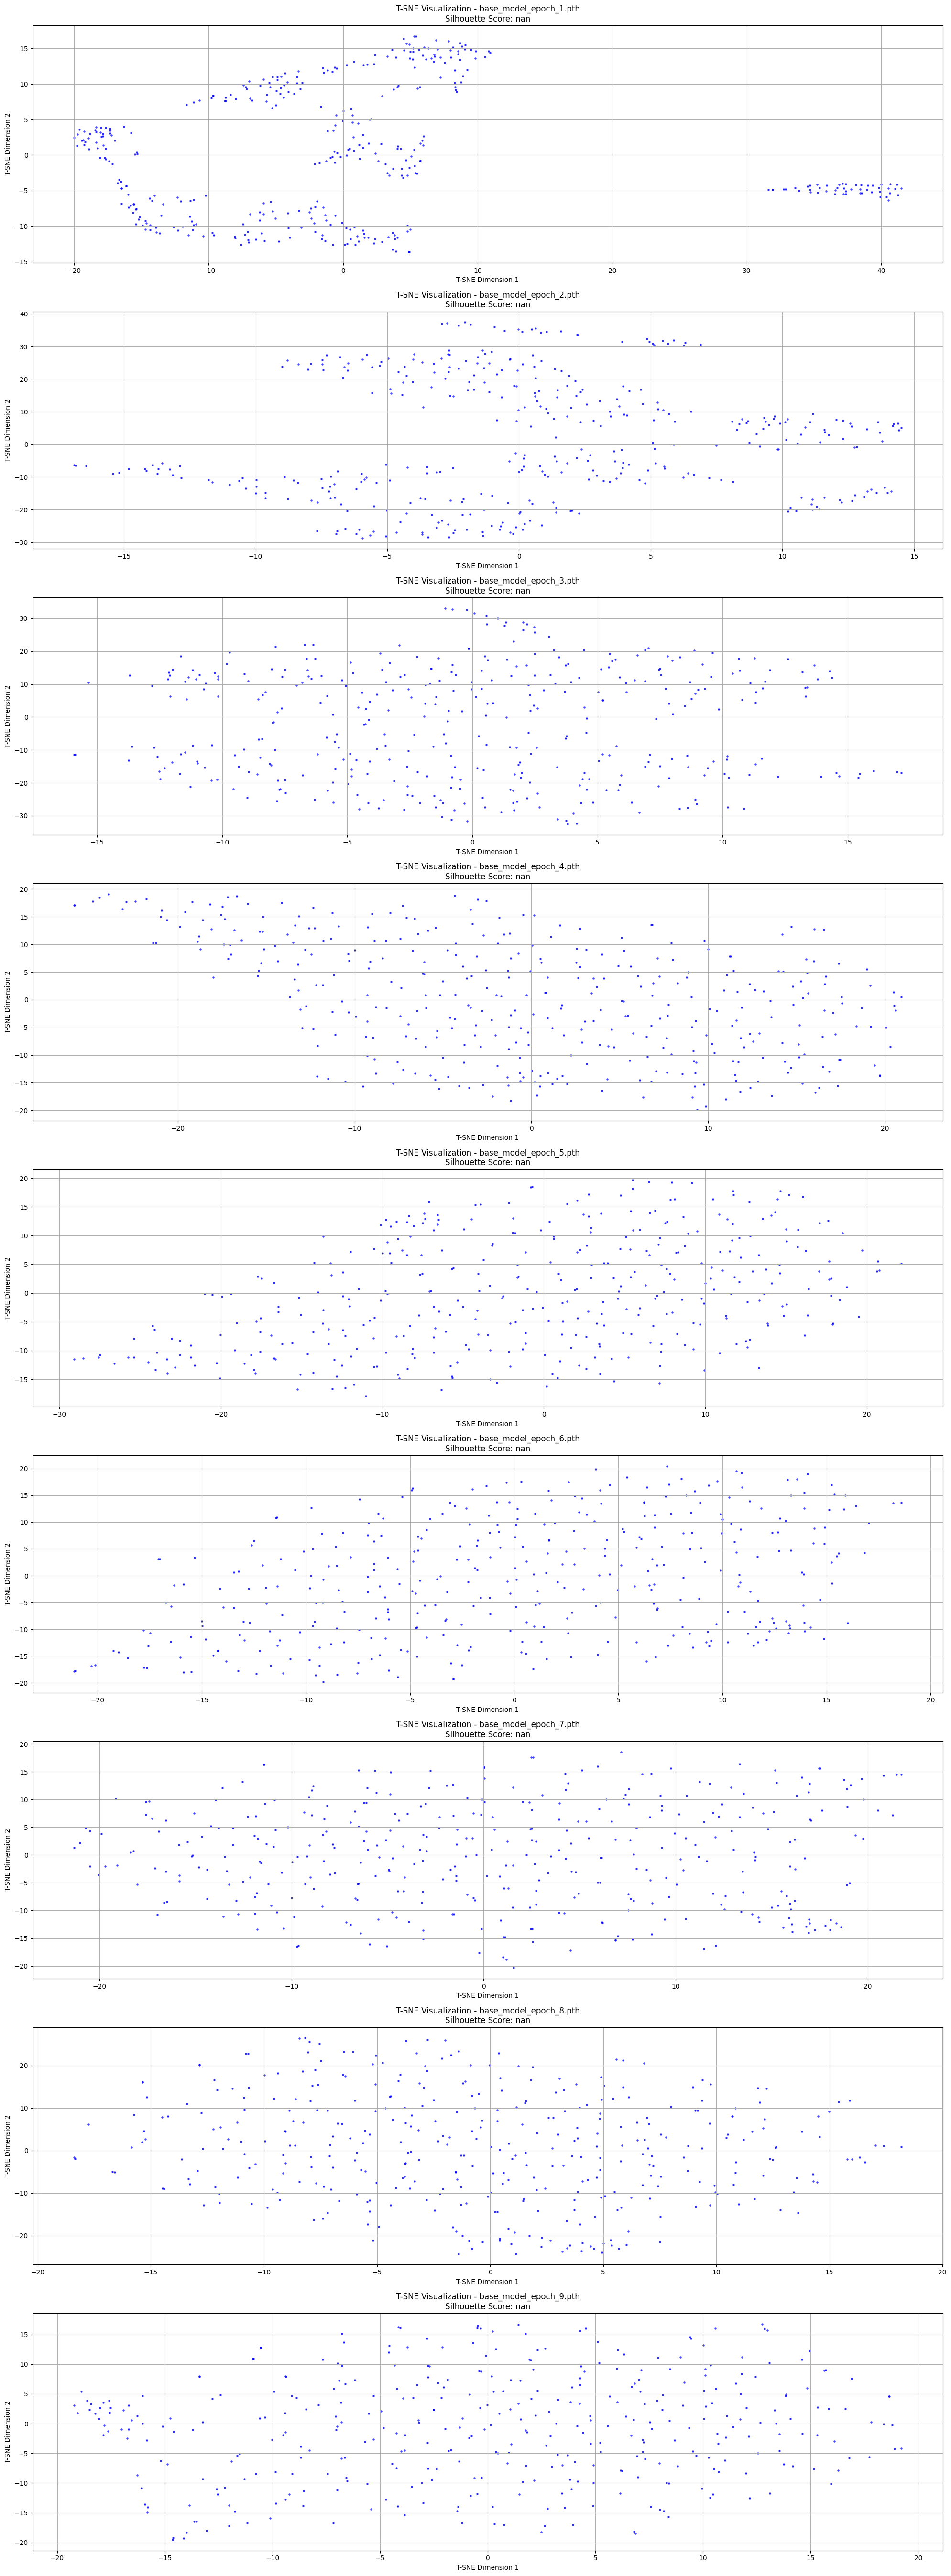


Silhouette Scores by Checkpoint:
base_model_epoch_1.pth: nan
base_model_epoch_2.pth: nan
base_model_epoch_3.pth: nan
base_model_epoch_4.pth: nan
base_model_epoch_5.pth: nan
base_model_epoch_6.pth: nan
base_model_epoch_7.pth: nan
base_model_epoch_8.pth: nan
base_model_epoch_9.pth: nan


In [ ]:
def plot_tsne_for_checkpoints(checkpoint_dir, data_loader, device, base_model):
    """
    Load multiple trained models from checkpoint files, compute T-SNE visualizations,
    and calculate silhouette scores for their extracted features using the same batch of data.

    Args:
        checkpoint_dir (str): Directory containing the trained model's checkpoint files.
        data_loader (DataLoader): PyTorch DataLoader providing the dataset.
        device (torch.device): Device for computation ('cuda' or 'cpu').
        base_model (nn.Module): The base model architecture to load the checkpoints into.
    """
    # Extract a single batch of images from the DataLoader
    images_batch = next(iter(data_loader))
    images = [img.to(device) for img in images_batch]

    # Iterate through all checkpoint files in the directory
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')])
    if not checkpoint_files:
        print(f"No checkpoint files found in {checkpoint_dir}.")
        return

    # Prepare the plot
    plt.figure(figsize=(20, len(checkpoint_files) * 6))

    for i, checkpoint_file in enumerate(checkpoint_files):
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

        # Load the model checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Handle different checkpoint formats
        if "student_state_dict" in checkpoint:
            base_model.load_state_dict(checkpoint["student_state_dict"])
        else:
            base_model.load_state_dict(checkpoint)  # Assume the entire state_dict is saved
        base_model.eval()

        with torch.no_grad():
            # Extract features for the batch
            features = [base_model(img) for img in images]
            features = torch.cat(features).cpu().numpy()

        # Compute T-SNE transformation
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        features_2d = tsne.fit_transform(features)

        # Plot T-SNE
        plt.subplot(len(checkpoint_files), 1, i + 1)
        plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.7, s=5, c='blue')
        plt.title(f"T-SNE Visualization - {checkpoint_file}\nSilhouette Score: {silhouette:.4f}")
        plt.xlabel("T-SNE Dimension 1")
        plt.ylabel("T-SNE Dimension 2")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
checkpoint_dir = '/content/checkpoints'
plot_tsne_and_silhouette_for_checkpoints(checkpoint_dir, data_loader, device, base_model)


# Labeled Data Extraction

### Functionality
1. **Source and Destination Folders**:
   - The `source_folder_path` contains the `.tar.xz` files.
   - The `destination_folder_path` is where the extracted files will be stored.

2. **Extraction Process**:
   - Iterates through all `.tar.xz` files in the source folder.
   - Extracts their contents directly into the destination folder.

3. **Key Features**:
   - Prevents nested folder structures by extracting files directly.
   - Ensures all `.tar.xz` files in the source folder are handled efficiently.

In [ ]:
# Define the source and destination folder paths
source_folder_path = '/content/drive/MyDrive/Huron_Labelled_Data'
labeled_data_dir = '/content/Labeled_Data'

def extract_all_tar_xz(source_folder_path, destination_folder_path):

    # Iterate through all files in the source folder
    for file_name in os.listdir(source_folder_path):
        if file_name.endswith('.tar.xz'):
            tar_file_path = os.path.join(source_folder_path, file_name)

            print(f"Extracting {file_name} into {destination_folder_path}...")

            # Extract the .tar.xz file directly into the destination folder
            with tarfile.open(tar_file_path, 'r:xz') as tar:
                tar.extractall(path=destination_folder_path)

            print(f"Finished extracting {file_name}.")

    print("All .tar.xz files have been successfully extracted.")

# Call the function to extract all .tar.xz files
extract_all_tar_xz(source_folder_path, labeled_data_dir)


Extracting Preview_Tiles_Ink_Marks.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Ink_Marks.tar.xz.
Extracting Preview_Tiles_Faint_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Faint_Tissue.tar.xz.
Extracting Preview_Tiles_With_No_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_With_No_Tissue.tar.xz.
Extracting Preview_Tiles_Small_One_Piece_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Small_One_Piece_Tissue.tar.xz.
Extracting Preview_Tiles_Small_Fragmented_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Small_Fragmented_Tissue.tar.xz.
Extracting Preview_Tiles_Large_Solid_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Large_Solid_Tissue.tar.xz.
Extracting Preview_Tiles_With_Some_Faint_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_With_Some_Faint_Tissue.tar.xz.
All .tar.xz files 

# Preparing Labelled Datasets and DataLoaders

### 1. **Function to Remove Hidden Folders**
The `remove_hidden_folders` function removes any hidden folders (e.g., `.ipynb_checkpoints`) from the dataset directory.

- **Implementation**:
  - The function uses `os.walk()` to traverse the folder hierarchy.
  - It identifies hidden folders by checking if the folder name starts with a dot (`.`).
  - Detected hidden folders are removed using `os.rmdir()`.

---

### 2. **Function to Prepare Datasets and DataLoaders**
The `prepare_datasets_and_loaders` function prepares the dataset for training, validation, and testing by splitting it into separate subsets and creating DataLoaders.

- **Steps**:
  1. **Clean Hidden Folders**:
     - Calls `remove_hidden_folders` to clean the dataset directory.
  2. **Define Data Transformations**:
     - Uses `torchvision.transforms` to apply preprocessing steps:
       - Resize images to 224x224 pixels.
       - Convert images to tensors.
       - Normalize images using the mean and standard deviation of the ImageNet dataset.
  3. **Load Dataset**:
     - Loads the dataset using `ImageFolder`, which expects images organized in subdirectories corresponding to their class labels.
  4. **Split Dataset**:
     - Splits the dataset into training, validation, and test sets using `random_split`. The ratios for the splits are specified as parameters (`train_ratio`, `valid_ratio`, and `test_ratio`).
  5. **Create DataLoaders**:
     - Creates `DataLoader` objects for the training, validation, and test datasets. DataLoaders handle batching, shuffling, and parallel data loading.

- **Print Information**:
  - Prints the mapping of class names to indices (`class_to_idx`) and the sizes of each dataset split.

- **Returns**:
  - The DataLoaders (`train_loader`, `valid_loader`, `test_loader`) and the class-to-index mapping (`class_to_idx`).

---

### 3. **Usage Example**
After preparing the datasets:
- **Iterate Through a Batch**:
  - Demonstrates how to fetch a batch of data from the training DataLoader.
  - Prints the size of the batch and the corresponding labels.

---





In [ ]:
# Function to remove hidden folders (e.g., .ipynb_checkpoints)
def remove_hidden_folders(folder_path):
    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            if dir_name.startswith('.'):  # Hidden folder detection
                full_path = os.path.join(root, dir_name)
                print(f"Removing hidden folder: {full_path}")
                os.rmdir(full_path)

# Function to prepare datasets and DataLoaders
def prepare_datasets_and_loaders(data_dir, batch_size=32, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):

    # Clean hidden folders
    remove_hidden_folders(data_dir)

    # Define transformations for preprocessing
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])


    dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    valid_size = int(valid_ratio * dataset_size)
    test_size = dataset_size - train_size - valid_size

    train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

    # Create DataLoaders for each split
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Print dataset sizes and class-to-index mapping
    print("Class-to-Index Mapping:", dataset.class_to_idx)
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(valid_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    return train_loader, valid_loader, test_loader, dataset.class_to_idx

# Prepare datasets and DataLoaders
train_loader, valid_loader, test_loader, class_to_idx = prepare_datasets_and_loaders(labeled_data_dir)

#Iterate through one batch from the train_loader
for images, labels in train_loader:
    print(f"Batch size: {images.size()}, Labels: {labels}")
    break


Class-to-Index Mapping: {'Preview Tiles Small Fragmented tissue': 0, 'Preview Tiles Small One Piece Tissue': 1, 'Preview Tiles with No Tissue': 2, 'Preview Tiles with Some Faint Tissue': 3, 'Preview Tiles_Faint Tissue': 4, 'Preview Tiles_Ink Marks': 5, 'Preview Tiles_Large Solid Tissue': 6}
Total dataset size: 995
Training set size: 696
Validation set size: 199
Test set size: 100
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([6, 1, 4, 1, 6, 4, 5, 0, 5, 5, 3, 2, 2, 6, 6, 5, 3, 4, 6, 5, 4, 1, 5, 3,
        6, 4, 3, 5, 6, 5, 3, 2])


#Initializing New Classififcation Head

### 1. **Setting the Number of Classes**
The variable `num_classes` is set to `7`, representing the number of output classes the model will predict.

---

### 2. **Creating the Backbone Model**
- **Model Selection**:
  - A Vision Transformer (ViT) model with small architecture (`vit_small_patch16_224`) is created using the `timm` library.
  - The model is initialized with pretrained weights to leverage transfer learning.
- **Feature Dimension Extraction**:
  - The number of input features for the classification head (`in_dim`) is obtained from the existing head of the backbone model.

---

### 3. **Defining the Classification Head**
A custom classification head is defined as a `torch.nn.Sequential` module to replace the default head of the backbone.
- **Structure**:
  - A series of fully connected layers (`Linear`) and activation functions (`ReLU`).
  - Dropout layers (`Dropout`) are included to reduce overfitting.
  - The final layer outputs `num_classes` predictions.

The custom head is then assigned to the model’s `head`.

---

### 4. **Loading the Model Checkpoint**
- **Checkpoint Path**:
  - The checkpoint file is located at `/content/ham_small_model_epoch_3.pth`.
- **Loading Mechanism**:
  - The checkpoint is loaded using `torch.load` with the `map_location` set to handle GPU or CPU devices.
  - The `weights_only` argument ensures that only the model's weights are loaded, enhancing security.
- **Filtering Keys**:
  - A filtered version of the checkpoint is created to include only keys compatible with the model’s current architecture.
  - The `state_dict` of the backbone model is updated with these filtered weights.

---

### 5. **Handling Missing and Unexpected Keys**
- **Warnings**:
  - If certain keys from the checkpoint are not found in the model (`missing_keys`) or if unexpected keys are found (`unexpected_keys`), warnings are printed.
  - This ensures transparency about the checkpoint loading process.

---

### 6. **Testing the Model**
- **Dummy Input**:
  - A dummy input tensor of shape `[1, 3, 224, 224]` (1 image, 3 color channels, 224x224 resolution) is created and sent to the appropriate device (GPU or CPU).
- **Forward Pass**:
  - The model processes the input and outputs predictions with a shape of `[1, num_classes]`.
- **Output Verification**:
  - The output shape is printed to confirm that the model correctly predicts probabilities for `num_classes`.

---

In [ ]:
# Define parameters
num_classes = 7
checkpoint_path = '/content/checkpoints/base_model_epoch_9.pth'  # Update this path as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the backbone model and classification head
backbone = timm.create_model('vit_small_patch16_224', pretrained=True)
in_dim = backbone.head.in_features

classification_head = nn.Sequential(
    nn.Linear(in_dim, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

backbone.head = classification_head
backbone = backbone.to(device)

# Load checkpoint
if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Filter checkpoint keys to match the backbone model state_dict
    model_state_dict = backbone.state_dict()
    filtered_checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

    # Load the filtered state_dict
    missing_keys, unexpected_keys = backbone.load_state_dict(filtered_checkpoint, strict=False)

    # Print warnings if there are missing or unexpected keys
    if missing_keys:
        print(f"Warning: Missing keys during loading: {missing_keys}")
    if unexpected_keys:
        print(f"Warning: Unexpected keys during loading: {unexpected_keys}")
else:
    print(f"Checkpoint not found at {checkpoint_path}. Starting with a fresh model.")

# Test the model with dummy data
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = backbone(dummy_input)
print("Output shape:", output.shape)  # Should be [1, num_classes]


Loading checkpoint from: /content/checkpoints/base_model_epoch_9.pth
Output shape: torch.Size([1, 7])


<ipython-input-29-4c14e5db7421>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


#CLASS COUNTS AND WEIGHTS

In [ ]:
# Calculate class weights for imbalanced datasets
#class_counts = Counter([label for _, label in train_loader.dataset])
#class_weights = [1.0 / class_counts[c] for c in range(len(class_counts))]
#class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class_counts = {6: 213, 5: 100, 3: 93, 4: 83, 0: 75, 1: 67, 2: 65}
class_weights = {
    5: 0.0133,
    4: 0.0149,
    1: 0.0154,
    3: 0.0108,
    2: 0.0120,
    0: 0.0100,
    6: 0.0047
}

# Convert class weights to a tensor
class_weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

# Output the class counts
print("Class Counts:", class_counts)

NameError: name 'torch' is not defined

#PASS RANDOM LABELLED IMAGE THROUGH ENCODER

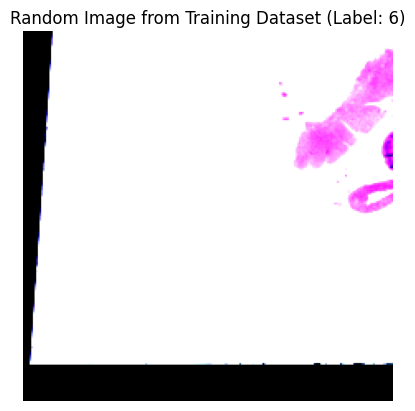

Preprocessed Image Shape: torch.Size([1, 3, 224, 224])
Preprocessed Image Tensor (First Channel):
tensor([[-1.8439, -1.8268, -1.8268,  ...,  2.2147,  2.1975,  2.2147],
        [-1.7925, -1.8268, -1.9124,  ...,  2.2318,  2.2147,  2.2147],
        [-1.8097, -1.8610, -1.9124,  ...,  2.2147,  2.2147,  2.2147],
        ...,
        [-2.0837, -2.1008, -2.0837,  ..., -2.1008, -2.0665, -2.0665],
        [-2.0837, -2.0837, -2.0665,  ..., -2.0837, -2.0837, -2.1008],
        [-2.0837, -2.0837, -2.1008,  ..., -2.0665, -2.1008, -2.0837]],
       device='cuda:0')
Patch Embedding Shape: torch.Size([1, 196, 384])
Transformer Block 1 Output Shape: torch.Size([1, 196, 384])
Transformer Block 2 Output Shape: torch.Size([1, 196, 384])
Transformer Block 3 Output Shape: torch.Size([1, 196, 384])
Transformer Block 4 Output Shape: torch.Size([1, 196, 384])
Transformer Block 5 Output Shape: torch.Size([1, 196, 384])
Transformer Block 6 Output Shape: torch.Size([1, 196, 384])
Transformer Block 7 Output Shape: t

In [ ]:
# Set device

# Get a random batch from the training DataLoader
random_batch = next(iter(train_loader))  # Fetch the first batch
images, labels = random_batch  # Unpack the batch into images and labels

# Select a random image from the batch
random_idx = random.randint(0, images.size(0) - 1)  # Random index within the batch
random_image = images[random_idx]
random_label = labels[random_idx]

# Display the random image
plt.imshow(random_image.permute(1, 2, 0).cpu().numpy())  # Convert from CxHxW to HxWxC
plt.title(f"Random Image from Training Dataset (Label: {random_label.item()})")
plt.axis('off')
plt.show()

# Add batch dimension and move the image to the appropriate device
preprocessed_image = random_image.unsqueeze(0).to(device)

# Check the preprocessed image
print(f"Preprocessed Image Shape: {preprocessed_image.shape}")
print(f"Preprocessed Image Tensor (First Channel):\n{preprocessed_image[0, 0]}")

# Pass the image through the backbone encoder
backbone.eval()
with torch.no_grad():
    intermediate_results = []

    # Forward pass through the patch embedding layer
    patch_embed = backbone.patch_embed(preprocessed_image)
    print(f"Patch Embedding Shape: {patch_embed.shape}")
    intermediate_results.append(("Patch Embedding", patch_embed.cpu().numpy()))

    # Forward pass through the transformer blocks
    transformer_output = patch_embed
    for idx, block in enumerate(backbone.blocks):
        transformer_output = block(transformer_output)
        print(f"Transformer Block {idx + 1} Output Shape: {transformer_output.shape}")
        intermediate_results.append((f"Transformer Block {idx + 1}", transformer_output.cpu().numpy()))

    # Forward pass through the head (classification head)
    cls_token = transformer_output[:, 0]  # Extract the [CLS] token
    logits = backbone.head(cls_token)
    print(f"Logits Shape: {logits.shape}")
    intermediate_results.append(("Logits", logits.cpu().numpy()))

# Display final logits
print(f"Final Logits: {logits}")


In [ ]:
# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone.to(device)

# Freeze the backbone parameters
for param in backbone.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in backbone.head.parameters():
    param.requires_grad = True

# Define the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer for the classification head only
optimizer = optim.Adam(backbone.head.parameters(), lr=0.001, weight_decay=1e-5)

# Training parameters
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training phase
    backbone.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = backbone(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Validation phase
    backbone.eval()
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = backbone(images)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            total_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

    valid_loss = total_valid_loss / len(valid_loader)
    valid_accuracy = correct_valid / total_valid * 100

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    print(f"  Time Taken: {time.time() - start_time:.2f} seconds")

Epoch [1/10]
  Train Loss: 1.9790, Train Accuracy: 14.22%
  Valid Loss: 1.9413, Valid Accuracy: 9.05%
  Time Taken: 4.16 seconds
Epoch [2/10]
  Train Loss: 1.9302, Train Accuracy: 14.66%
  Valid Loss: 1.9502, Valid Accuracy: 12.06%
  Time Taken: 4.34 seconds
Epoch [3/10]
  Train Loss: 1.9321, Train Accuracy: 12.93%
  Valid Loss: 1.9530, Valid Accuracy: 12.06%
  Time Taken: 4.28 seconds
Epoch [4/10]
  Train Loss: 1.9313, Train Accuracy: 15.52%
  Valid Loss: 1.9602, Valid Accuracy: 12.06%
  Time Taken: 4.20 seconds
Epoch [5/10]
  Train Loss: 1.9327, Train Accuracy: 14.37%
  Valid Loss: 1.9582, Valid Accuracy: 12.06%
  Time Taken: 4.11 seconds
Epoch [6/10]
  Train Loss: 1.9372, Train Accuracy: 14.22%
  Valid Loss: 1.9561, Valid Accuracy: 9.05%
  Time Taken: 4.19 seconds


KeyboardInterrupt: 